# Welcome to this lovely notebook. This is the extention of the notebook EDA with data preprocessing and modeling parts (LightGBM)

## In this notebook we are going to implement the following:

1. Runnig the base version of LightGBM
2. After running the base version of the model, we'll find the best downsampled version of data and best hyper parameters for highest recall and precision

## Importing all required libraries

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import shap
from datetime import datetime

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,\
classification_report, precision_recall_curve, auc, make_scorer, fbeta_score

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest

# Machine Learning - Algorithm
from lightgbm import LGBMClassifier

C:\Users\atans\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Let's get the data

In [2]:
train = pd.read_csv('fraudTrain.csv', index_col=0)
test = pd.read_csv('fraudTest.csv', index_col=0)

## 2 Let's split the data

In [3]:
X_train = train.drop(columns=['is_fraud'])
y_train = train['is_fraud']

X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

## 3 Creating additional columns which will be used

The columns that have to be added:
1. Day of week
2. Month
3. Hour
4. Age of user

In [4]:
current_date = datetime.now()

for dataset in [X_train, X_test]:
    dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'])
    dataset['dob'] = pd.to_datetime(dataset['dob'])
    dataset['day_of_week'] = dataset['trans_date_trans_time'].dt.day_name()
    dataset['month'] = dataset['trans_date_trans_time'].dt.month
    dataset['hour'] = dataset['trans_date_trans_time'].dt.hour
    dataset['age'] =dataset['dob'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

## 4 Dropping the columns we are not going to use

In [5]:
X_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'day_of_week', 'month', 'hour', 'age'],
      dtype='object')

In [6]:
for dataset in [X_train, X_test]:
    dataset.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time', 'lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

## 4.1 Encoding categorical features and running 'trial' models

In [7]:
X_train.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'city_pop',
       'job', 'day_of_week', 'month', 'hour', 'age'],
      dtype='object')

In [8]:
%%time
# Step 1: Separate categorical and numerical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'day_of_week']
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' to avoid multicollinearity

# Step 3: Apply OneHotEncoder to the categorical columns in X_train (fit the encoder)
encoded_categorical_train = encoder.fit_transform(X_train[categorical_columns])

# Step 4: Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_columns))

# Step 5: Concatenate the numerical columns with the encoded categorical columns for X_train
X_train_encoded = pd.concat([X_train[numerical_columns].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

# Now apply the same transformation to the test data (use transform instead of fit_transform)
encoded_categorical_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numerical columns with the encoded categorical columns for X_test
X_test_encoded = pd.concat([X_test[numerical_columns].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 46.8 s
Wall time: 2min 6s


#### Removing some special symbols from the names of the features

In [13]:
X_train_encoded.columns = X_train_encoded.columns.str.replace(r'[^\w]', '_', regex=True)
X_test_encoded.columns = X_test_encoded.columns.str.replace(r'[^\w]', '_', regex=True)

#### Saving encoded train adn test data

In [14]:
X_train_encoded.to_parquet('X_train_encoded.csv', index=False)
X_test_encoded.to_parquet('X_test_encoded.csv', index=False)

#### Opening encoded train adn test data

In [4]:
X_train_encoded = pd.read_parquet('X_train_encoded.csv')
X_test_encoded = pd.read_parquet('X_test_encoded.csv')

### 5.1 Testing LightGBM with binary_logloss metric

In [5]:
%%time
# Step 1: Initialize the XGBoost Classifier
model_5 = LGBMClassifier(objective='binary', metric='binary_logloss')

# Step 2: Train the model on the training data
model_5.fit(X_train_encoded, y_train)

# Step 3: Predict on the training data
y_train_pred = model_5.predict(X_train_encoded)

# Step 4: Predict on the test data
y_test_pred = model_5.predict(X_test_encoded)

# Step 5: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Step 6: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4752
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 2086
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146050
[LightGBM] [Info] Start training from score -5.146050
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.75      0.62      0.68      7506

    accuracy                           1.00   1296675
   macro avg       0.87      0.81      0.84   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    reca

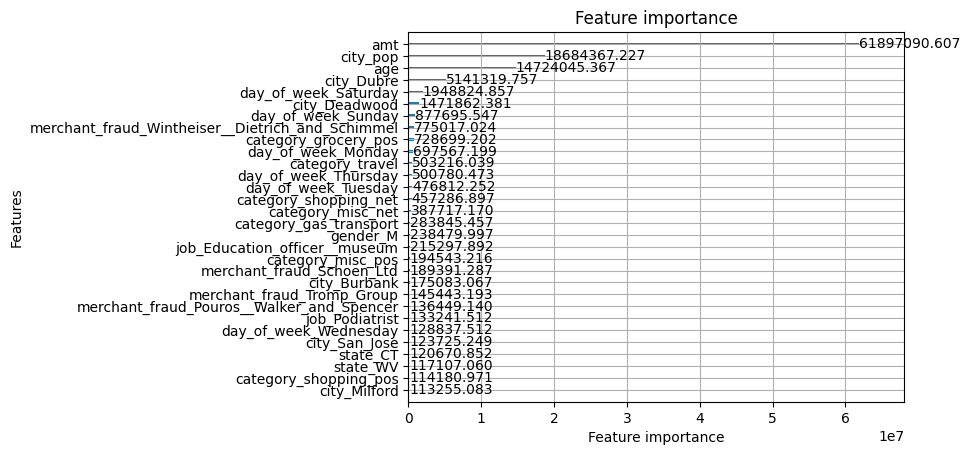

In [8]:
import lightgbm as lgb
# Assuming model_5 is your trained LightGBM model
lgb.plot_importance(model_5, importance_type='gain', max_num_features=30)
plt.show()

In [12]:
# Get feature importances
importances = model_5.feature_importances_

# Count how many features were used (non-zero importance)
used_features_count = (importances > 0).sum()

print(f"Number of features used by the model: {used_features_count}")

Number of features used by the model: 380


In [10]:
#Looks pretty cool! Even better than for XGBoost with base params on 100% of data
#The results look quite good! for the very first run
#Interestingly enough the features the model used look different from the features which were used by XGBoost

In [11]:
# Now we can try a few more things like:
# 1. We can try to downsample the train data and see if it improves the results
# 2. We can try to play with hyper parameters

### 5.2 Testing SelectKBest as we see memory related issues, we'll try 1000 and 500

In [17]:
# Step 1: Initialize SelectKBest to select top 500 features
for k in [1000, 500]:
    selector = SelectKBest(score_func=f_classif, k=k)

    # Step 2: Fit selector on training data and transform it
    X_train_encoded_selected = selector.fit_transform(X_train_encoded, y_train)

    # Step 3: Transform test data using the fitted selector
    X_test_encoded_selected = selector.transform(X_test_encoded)
    
    # Convert the numpy array back to pandas DataFrame
    X_train_encoded_selected_df = pd.DataFrame(X_train_encoded_selected, columns=selector.get_feature_names_out())
    X_test_encoded_selected_df = pd.DataFrame(X_test_encoded_selected, columns=selector.get_feature_names_out())
    
    X_train_encoded_selected_df.to_parquet(f'X_train_encoded_selected_{k}.parquet', index=False)
    X_test_encoded_selected_df.to_parquet(f'X_test_encoded_selected_{k}.parquet', index=False)

#### Running a loop on dfs with 1000 and 500 features to see how it affects the base run

In [6]:
%%time
for features in [1000, 500]:
    X_train_encoded_selected_ = pd.read_parquet(f'X_train_encoded_selected_{features}.parquet')
    X_test_encoded_selected_ = pd.read_parquet(f'X_test_encoded_selected_{features}.parquet')
    
    # Step 1: Initialize the XGBoost Classifier
    model_5 = LGBMClassifier(objective='binary', metric='binary_logloss')

    # Step 2: Train the model on the training data
    model_5.fit(X_train_encoded_selected_, y_train)

    # Step 3: Predict on the training data
    y_train_pred = model_5.predict(X_train_encoded_selected_)

    # Step 4: Predict on the test data
    y_test_pred = model_5.predict(X_test_encoded_selected_)

    print(f'These are the results for {features} features train and test datasets')
    # Step 5: Generate the classification report for training data
    print("Classification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))

    # Step 6: Generate the classification report for test data
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.371776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 935
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146050
[LightGBM] [Info] Start training from score -5.146050
These are the results for 1000 features train and test datasets
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.69      0.52      0.59      7506

    accuracy                           1.00   1296675
   macro avg       0.84      0.76      0.79   1296675
weighted avg       1.00      1.00      1.00   1296675


Class

In [8]:
X_train_encoded_selected_.shape

(1296675, 500)

In [10]:
# Strangely enough reducing the number of features affected the results negatively

### Conclusion
1. We improved the time of runnig significatly
2. Strangely enough 500 features work better than 1000
3. We'll try to run LightGBM with downsampling on all features anyway

### 5.3 Trying downsampling of not fraudulent rows of train data all the possible features, apart from long and lat and testing LightGBM with binary_logloss metric

### Running a loop with various downsample options, we also want to save all the features that the model used, in order to filter our incoded df for it to be lighter as the input

In [4]:
%%time

X_train_encoded_5_3 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_5_3 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_5_3 = X_train_encoded_5_3.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_3[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_3[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]


for frac in [1.0, 0.8, 0.5, 0.25, 0.1, 0.05]:

    # Step 2: Downsample the majority class (0s) by frac
    # Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
    X_train_0_downsampled = X_train_encoded_0.sample(frac=frac, random_state=42)
    y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

    # Step 3: Concatenate the downsampled majority class with the minority class
    X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
    y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

    # Step 4: Shuffle the dataset to mix the downsampled rows
    X_train_downsampled_5_3 = X_train_downsampled.sample(frac=1, random_state=42)
    y_train_downsampled_5_3 = y_train_downsampled.loc[X_train_downsampled_5_3.index]  # Align y_train after shuffling

    # Step 5: Initialize the XGBoost Classifier
    model_5_3 = LGBMClassifier(objective='binary', metric='binary_logloss') 
    
    # Step 6: Train the model on the training data
    model_5_3.fit(X_train_downsampled_5_3, y_train_downsampled_5_3)

    # Step 7: Predict on the training data
    y_train_pred = model_5_3.predict(X_train_downsampled_5_3)

    # Step 8: Predict on the test data
    y_test_pred = model_5_3.predict(X_test_encoded_5_3)

    print('\n')
    print(f'This is a set of results for frac: {frac*100} %')
    print('\n')

    # Step 9: Generate the classification report for training data
    print("Classification Report for Training Data:")
    print(classification_report(y_train_downsampled_5_3, y_train_pred))

    # Step 10: Generate the classification report for test data
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4761
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 2091
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146050
[LightGBM] [Info] Start training from score -5.146050


This is a set of results for frac: 100.0 %


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.77      0.60      0.68      7506

    accuracy                           1.00   1296675
   macro avg       0.89      0.80      0.84   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report

## So we see the following:
1. It terms of imbalanced data, training LightGBM on 50% of train data + all fraud gives pretty balanced results
2. Almost all features are used
3. The current run took 16 mins

### 5.4 Trying to run some hyper parameter tuning on 50% downsampling

In [7]:
%%time

X_train_encoded_5_4 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_5_4 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_5_4 = X_train_encoded_5_4.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_4[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_4[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_5_4 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_5_4 = y_train_downsampled.loc[X_train_downsampled_5_4.index]  # Align y_train after shuffling

for max_depth in [3, 5, 7]:
    for learning_rate in [0.05, 0.1, 0.2]:
        for n_estimators in [100, 200]:
            for scale_pos_weight in [0.6, 0.8, 1]:
                # Step 5: Initialize the Light GBM
                model_5_4 = LGBMClassifier(
                                          metric='binary_logloss',
                                         max_depth=max_depth, n_estimators=n_estimators,
                                         learning_rate=learning_rate, scale_pos_weight=scale_pos_weight)  

                # Step 6: Train the model on the training data
                model_5_4.fit(X_train_downsampled_5_4, y_train_downsampled_5_4)

                # Step 7: Predict on the training data
                y_train_pred = model_5_4.predict(X_train_downsampled_5_4)

                # Step 8: Predict on the test data
                y_test_pred = model_5_4.predict(X_test_encoded_5_4)

                print('\n')
                print(f'This is a set of results for 50% downsampling, depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}, scale_pos_weight={scale_pos_weight}')
                print('\n')
                #print how many features were used:

                # Step 9: Generate the classification report for training data
                print("Classification Report for Training Data:")
                print(classification_report(y_train_downsampled_5_4, y_train_pred))

                # Step 10: Generate the classification report for test data
                print("\nClassification Report for Test Data:")
                print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.58      0.70      7506

    accuracy                           0.99    652090
   macro avg       0.93      0.79      0.85    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.69      0.59      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.79      0.82    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=3, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.82      0.67      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.91      0.83      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.65      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.82      0.81    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for 50% downsampling, depth=3, learning_rate=0.05, n_estimators=100, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.82      0.68      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.91      0.84      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.66      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.83      0.81    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



This is a set of results for 50% downsampling, depth=3, learning_rate=0.05, n_estimators=200, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.82      0.69      0.75      7506

    accuracy                           0.99    652090
   macro avg       0.91      0.85      0.88    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.67      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.84      0.81    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=3, learning_rate=0.1, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.64      0.73      7506

    accuracy                           0.99    652090
   macro avg       0.93

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of result

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=3, learning_rate=0.1, n_estimators=100, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.82      0.72      0.77      7506

    

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=3, learning_rate=0.1, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.71      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.85      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



This is a set of results for 50% downsampling, depth=3, learning_rate=0.2, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    644584
           1       0.46      0.32      0.38      7506

    accuracy                           0.99    652090
   macro avg       0.73      0.66      0.68    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.21      0.30      0.24      2145

    accuracy                           0.99    555719
   macro avg       0.60      0.65      0.62    555719
weighted avg       0.99      0.99      0.99    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.65      0.66      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



This is a set of results for 50% downsampling, depth=5, learning_rate=0.05, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.69      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.67      0.65      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.82      0.83    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



This is a set of results for 50% downsampling, depth=5, learning_rate=0.1, n_estimators=100, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.67      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.62      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.81      0.83    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.64      0.67      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=5, learning_rate=0.1, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.72      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.86      0.89    652090
weighted avg       1.00      1.00      1.00 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=5, learning_rate=0.2, n_estimators=200, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.79      0.57      0.66      7506

    accuracy                           0.99    652090
   macro avg       0.89      0.78      0.83    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.47      0.49      0.48      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.74      0.74    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=7, learning_rate=0.05, n_estimators=200, scale_pos_weight=0.6


Classification Report for Training Data:
              p

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.62      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.83    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split



This is a set of results for 50% downsampling, depth=7, learning_rate=0.1, n_estimators=200, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.74      0.81      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.65      0.61      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.81      0.82    555719
weighted avg       1.00      1.00      1.00    555719

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

#### Best hyper parameters and results

In [9]:
print("""[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=7, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.69      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.84      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.66      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.83      0.84    555719
weighted avg       1.00      1.00      1.00    555719
""")

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


This is a set of results for 50% downsampling, depth=7, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.69      0.77      7506

    accuracy                           1

### Conclusion
1. Best training sample was 50% downsampled
2. Best results in this case are : 66% recall and 71% precision
3. Best set of params found: max_depth=7, learning_rate=0.05, n_estimators=100, scale_pos_weight=0.8

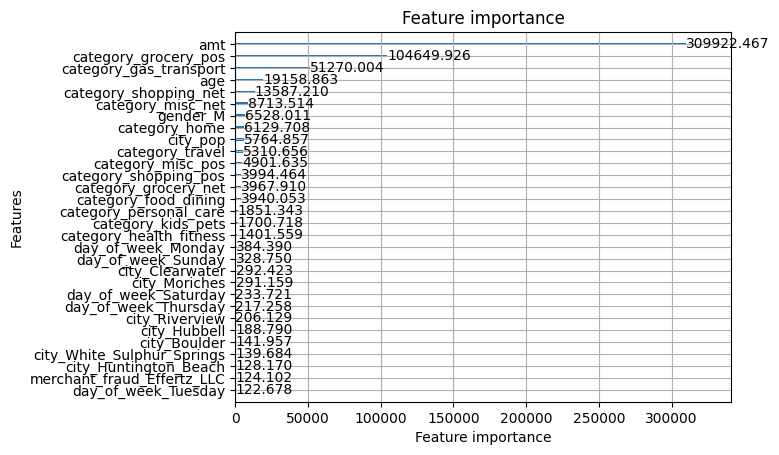

In [9]:
### Feature importance of the model with best results
import lightgbm
# Plot feature importance
lightgbm.plot_importance(model_6, importance_type='gain', max_num_features=30)  # You can change to 'weight' or 'cover'
plt.show()

## 6 Summary plot with shap

In [4]:
%%time

X_train_encoded_6 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_6 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_6 = X_train_encoded_6.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_6[y_train == 0]
X_train_encoded_1 = X_train_encoded_6[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_6 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_6 = y_train_downsampled.loc[X_train_downsampled_6.index]

CPU times: total: 3min 18s
Wall time: 2min 50s


In [5]:
# Get all opened DataFrames in the current environment
dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]

print("List of DataFrames currently in memory:")
print(dfs)

List of DataFrames currently in memory:
['train', 'test', 'X_train', 'X_test', 'X_train_encoded_6', 'X_test_encoded_6', 'X_train_encoded_0', 'X_train_encoded_1', 'X_train_0_downsampled', 'X_train_downsampled', 'X_train_downsampled_6']


In [6]:
del train, test, X_train, X_test, X_train_encoded_6, X_train_encoded_0, X_train_encoded_1, X_train_0_downsampled, X_train_downsampled

In [7]:
model_6 = LGBMClassifier(metric='binary_logloss',
                        max_depth=7, n_estimators=100,
                        learning_rate=0.05, scale_pos_weight=0.8) 

# Step 1: Train the model on the training data
model_6.fit(X_train_downsampled_6, y_train_downsampled_6)

# Step 2: Predict on the training data
y_train_pred = model_6.predict(X_train_downsampled_6)

# Step 3: Predict on the test data
y_test_pred = model_6.predict(X_test_encoded_6)

# Step 4: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train_downsampled_6, y_train_pred))

# Step 5: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 7506, number of negative: 644584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 652090, number of used features: 2084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011511 -> initscore=-4.452902
[LightGBM] [Info] Start training from score -4.452902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.69      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.84      0.89    652090
weighted avg       1.00      1.00      1.00    6520

C:\Users\atans\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


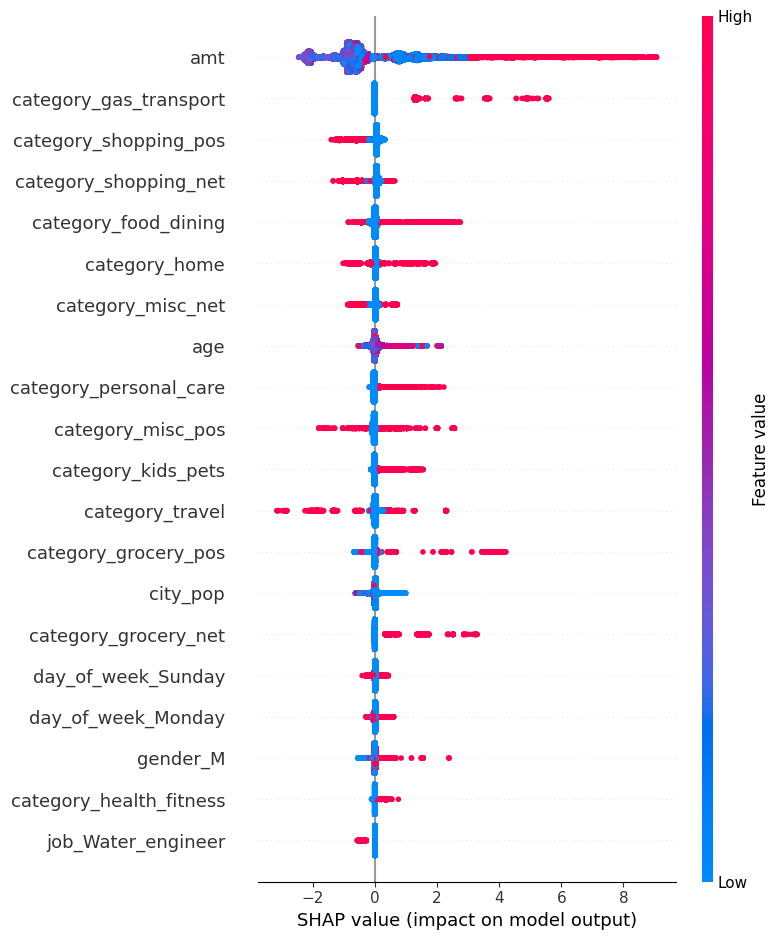

In [8]:
#Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(model_6)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded_6)

# Plot summary plot (feature importance plot) for top 20 features
shap.summary_plot(shap_values, X_test_encoded_6, max_display=20)